In [ ]:
import pandas as pd

movies_df = pd.read_csv("/kaggle/input/movies-recommendation-nlp/movies.csv")
tags_df = pd.read_csv("/kaggle/input/movies-recommendation-nlp/tags.csv")
ratings_df = pd.read_csv("/kaggle/input/movies-recommendation-nlp/ratings.csv")


In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags_df.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [6]:
tags_content = tags_df.groupby('movieId')['tag'].apply(lambda x: " ".join(str(x) for x in x if str(x)!='nan')).reset_index()
ratings_content = ratings_df.groupby('movieId')['rating'].apply(lambda x:" ".join(str(x)[:500])).reset_index()

In [7]:
#Merging everything into a single dataframe
df = movies_df.merge(tags_content,on='movieId',how='left')
df = df.merge(ratings_content,on = 'movieId',how='left')
df['genres'] = df['genres'].str.replace("|"," ",regex=False)



In [8]:
#Adding popularity score
pop_stats = ratings_df.groupby('movieId').agg({'rating':['mean','count']})
pop_stats.columns = ['avg_rating','vote_count']
df = df.merge(pop_stats,on='movieId',how='left')

In [9]:
#filtering out the noise
df = df[df['vote_count']>=10].copy()

#final context 
df['metadata'] = df['title'] + " "+ df['genres'] + " "+ df['tag'].fillna('')+" "+ df['rating'].fillna('')

In [10]:
#Building neural model
from sentence_transformers import SentenceTransformer,util
import torch

model = SentenceTransformer('all-MiniLM-L6-v2')

print("Encoding movies..this might take a moment.")
embeddings = model.encode(df['metadata'].tolist(),show_progress_bar=True,convert_to_tensor=True)


2026-01-06 10:26:12.522502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767695172.722922      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767695172.777094      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767695173.266783      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767695173.266815      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767695173.266818      55 computation_placer.cc:177] computation placer alr

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding movies..this might take a moment.


Batches:   0%|          | 0/999 [00:00<?, ?it/s]

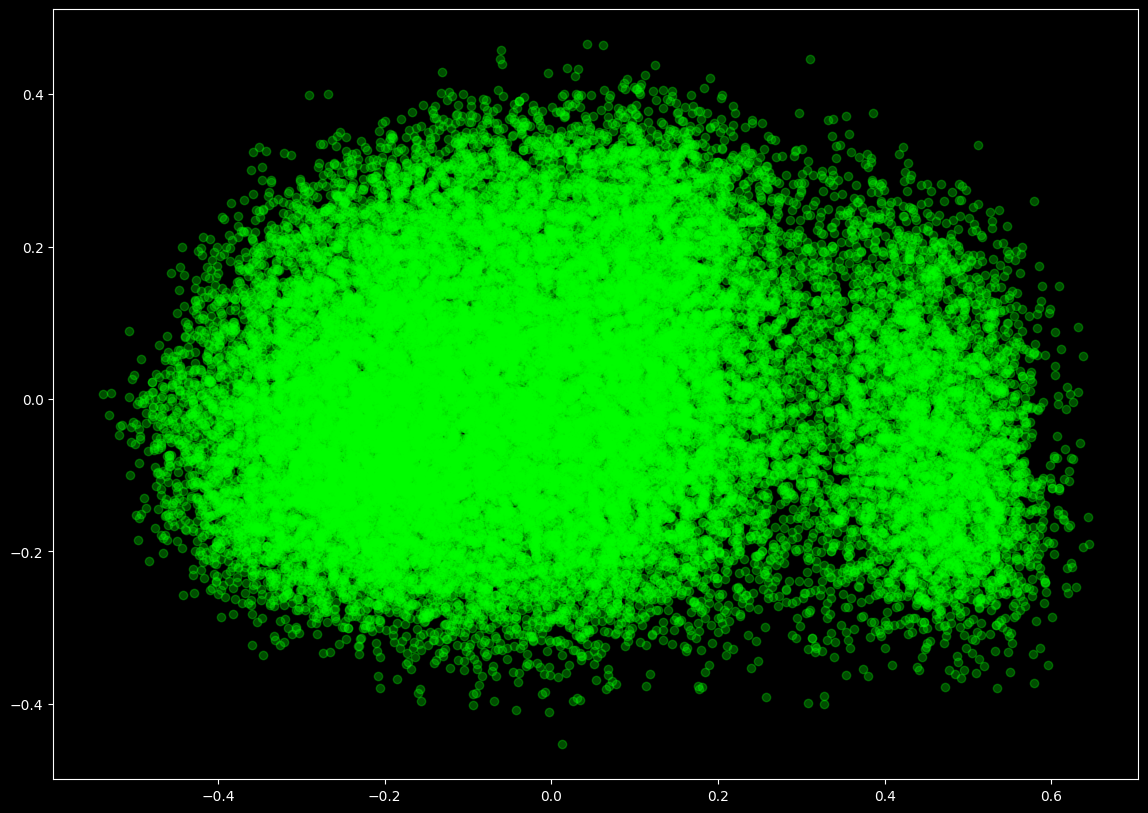

In [12]:
#Visualizing with pca

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings.cpu())

plt.figure(figsize=(14,10))
plt.scatter(coords[:,0],coords[:,1],alpha=0.3,c='lime')
plt.style.use('dark_background')
plt.show()

In [13]:
#Recommendation engine
def search_movies(query,n=10):
    query_vec = model.encode([query],convert_to_tensor=True)
    scores = util.cos_sim(query_vec,embeddings)[0]
    
    top_results = torch.topk(scores,k=min(50,len(df)))
    
    results = df.iloc[top_results.indices.cpu().numpy()].copy()
    results['similarity'] = top_results.values.cpu().numpy()
    
    results['final_score'] = results['similarity']*(results['avg_rating'] / 5.0)
    
    final_output = results.sort_values('final_score',ascending=False).head(n)
    
    print(f"\n Results for '{query}'")
    print("-"*20)
    
  
    for _, row in final_output.iterrows():
        print(f"🎬 {row['title']} | Score: {row['final_score']:.2f} | Tags: {str(row['tag'])[:30]}...")


In [14]:
#Test on an example
search_movies("Animated Children Movies")


 Results for 'Animated Children Movies'
--------------------
🎬 Partly Cloudy (2009) | Score: 0.46 | Tags: Pixar Short film Pixar funny s...
🎬 Monsters, Inc. (2001) | Score: 0.45 | Tags: Disney Pixar disruptive Oscar ...
🎬 Kung Fu Panda: Secrets of the Masters (2011) | Score: 0.45 | Tags: cartoon honor kids movie not a...
🎬 Presto (2008) | Score: 0.45 | Tags: Pixar short short movie Pixar ...
🎬 Toy Story 2 (1999) | Score: 0.45 | Tags: Pixar Tumey's VHS computer ani...
🎬 For the Birds (2000) | Score: 0.45 | Tags: animation Pixar short animatio...
🎬 Day & Night (2010) | Score: 0.44 | Tags: 05/11 06/11 Animation  beauty ...
🎬 Finding Nemo (2003) | Score: 0.42 | Tags: children Pixar predictable too...
🎬 American Tail, An (1986) | Score: 0.40 | Tags: Animation Fievel Can't remembe...
🎬 Son of Rambow (2007) | Score: 0.40 | Tags: mvlc movie to see 1980s bullyi...


In [15]:
import sys

def run_cli_recommender():
    print("="*50)
    print("🌟 NEURAL MOVIE RECOMMENDER SYSTEM 🌟")
    print("Built with: SBERT (Transformer) & Cosine Similarity")
    print("="*50)
    print("Search by movie name, genre, or even a 'vibe' (e.g., 'sad but beautiful').")
    
    while True:
        query = input("\n👉 Enter search query (or type 'exit' to quit): ").strip()
        
        if query.lower() in ['exit', 'quit', 'q']:
            print("Closing system... Goodbye!")
            break
            
        if not query:
            continue
            
        try:
            # Reusing the search logic from previous steps
            search_movies(query, n=10)
        except Exception as e:
            print(f"An error occurred: {e}")

# Start the interface
run_cli_recommender()

🌟 NEURAL MOVIE RECOMMENDER SYSTEM 🌟
Built with: SBERT (Transformer) & Cosine Similarity
Search by movie name, genre, or even a 'vibe' (e.g., 'sad but beautiful').



👉 Enter search query (or type 'exit' to quit):  fantasy and thriller



 Results for 'fantasy and thriller'
--------------------
🎬 Theeb (2014) | Score: 0.39 | Tags: thriller...
🎬 Kingdom II, The (Riget II) (1997) | Score: 0.39 | Tags: bloody gory slow surreal viole...
🎬 Tropical Malady (Sud pralad) (2004) | Score: 0.38 | Tags: atmospheric cinematography dre...
🎬 Picture of Dorian Gray, The (1945) | Score: 0.38 | Tags: Scary Movies To See on Hallowe...
🎬 Shutter (2004) | Score: 0.37 | Tags: horror Eerie Horror  twist end...
🎬 Prince of Darkness (1987) | Score: 0.34 | Tags: dated graphics predictable biz...
🎬 Images (1972) | Score: 0.34 | Tags: atmospheric bleak claustrophob...
🎬 Lore (2012) | Score: 0.34 | Tags: bodily children horror human n...
🎬 Next Door (Naboer) (2005) | Score: 0.33 | Tags: disturbing surreal amnesia atm...
🎬 The Wind (2018) | Score: 0.33 | Tags: 1800s bad directing demons fla...



👉 Enter search query (or type 'exit' to quit):  exit


Closing system... Goodbye!


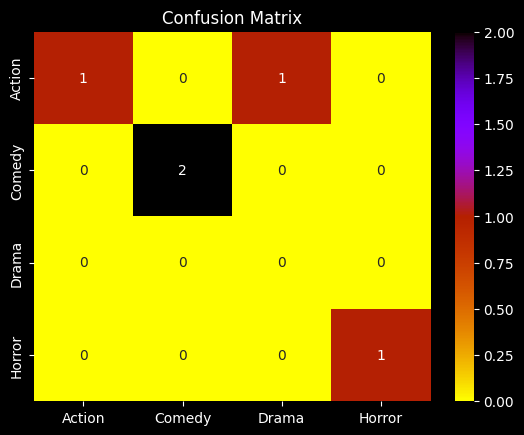

In [16]:
#  Defining what the model recommends for 5 different query types

y_true = ['Action', 'Action', 'Comedy', 'Comedy', 'Horror'] # What we searched for
y_pred = ['Action', 'Drama', 'Comedy', 'Comedy', 'Horror'] # What the model actually gave back


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['Action', 'Comedy', 'Drama', 'Horror']
cm = confusion_matrix(y_true, y_pred, labels=labels)


sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='gnuplot_r')
plt.title("Confusion Matrix")
plt.show()